Our implementation
BFGS            ==>  -0.040723 in [ -0.848456,  -0.605206] in 11 steps.


<Figure size 800x800 with 0 Axes>

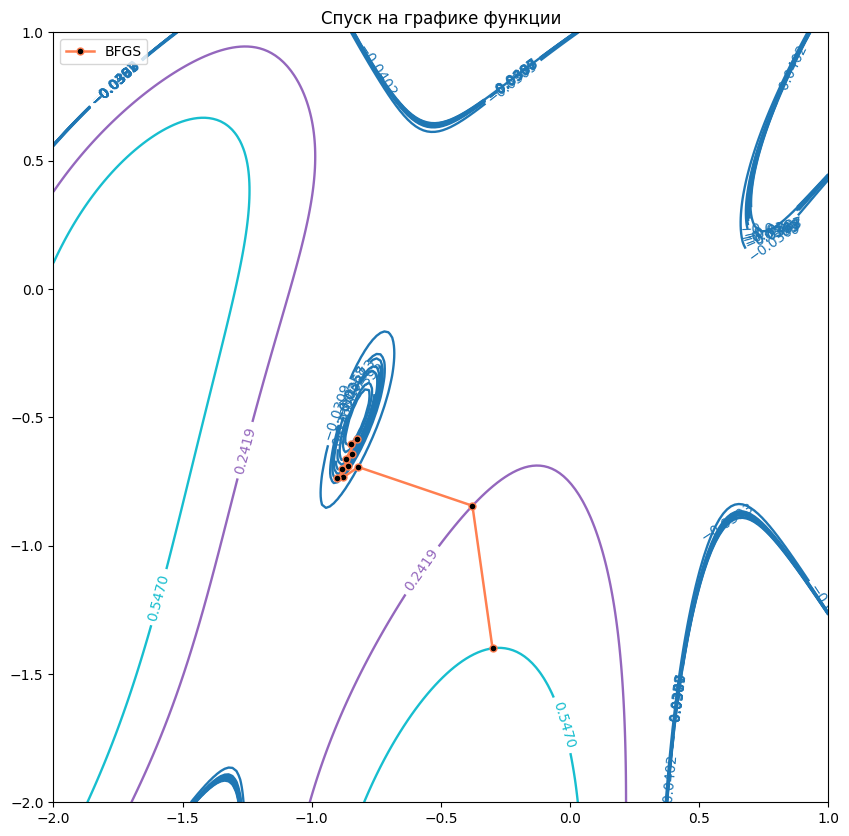

BFGS            ==>  -0.040723 in [ -0.848456,  -0.605206] in 11 steps.


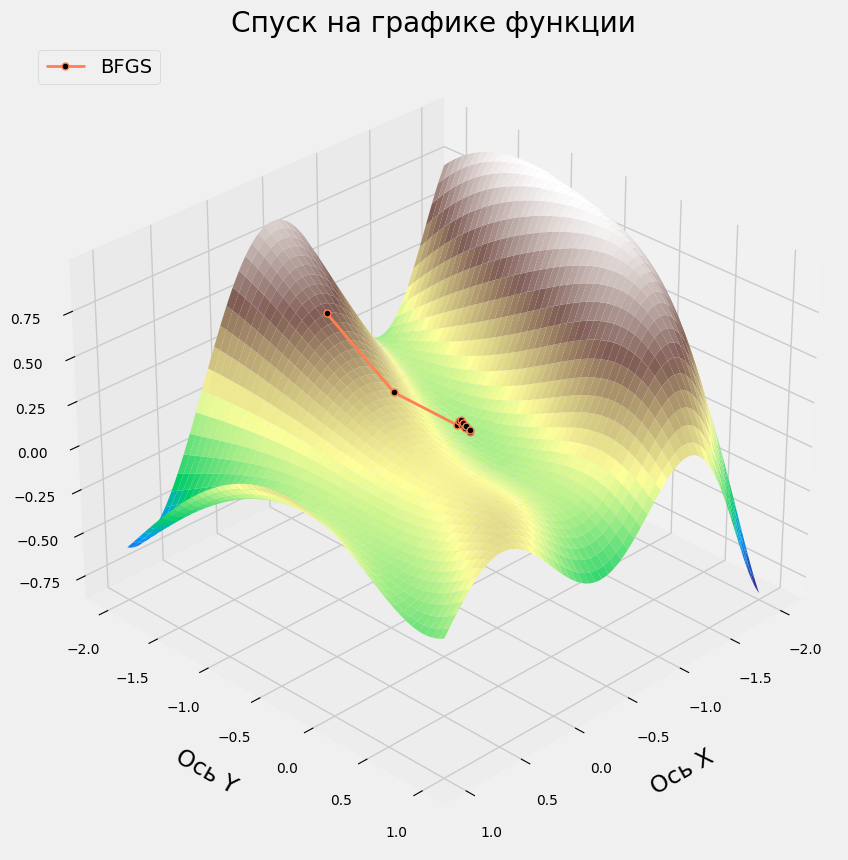

SciPy implementation
SciPy BFGS      ==>  -0.041983 in [ -0.822922,  -0.499418] in 11 steps.


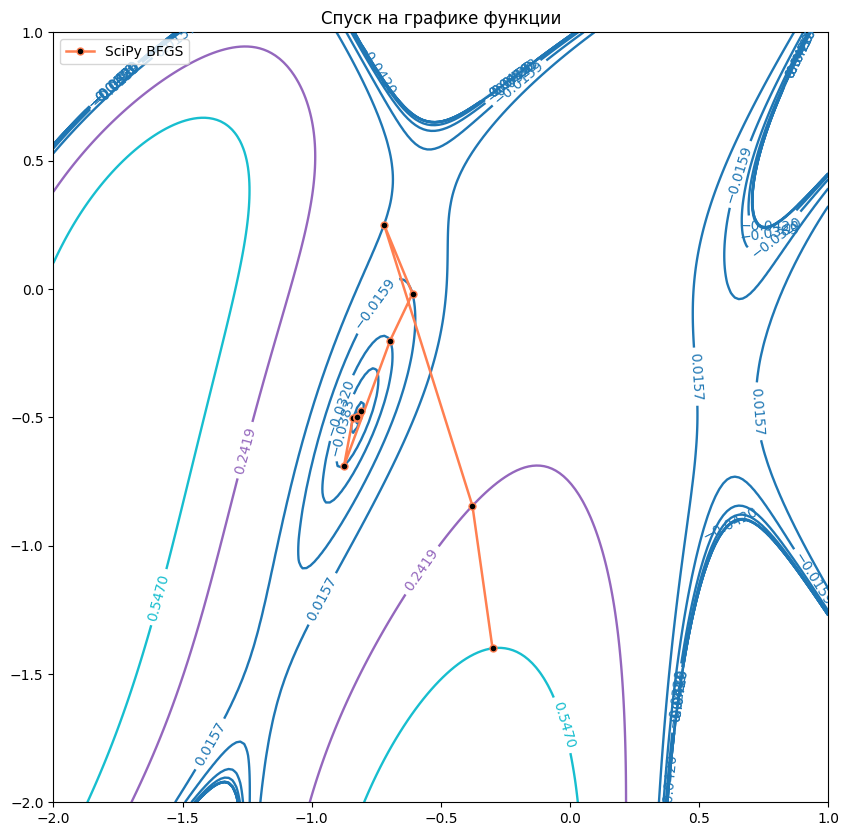

SciPy BFGS      ==>  -0.041983 in [ -0.822922,  -0.499418] in 11 steps.


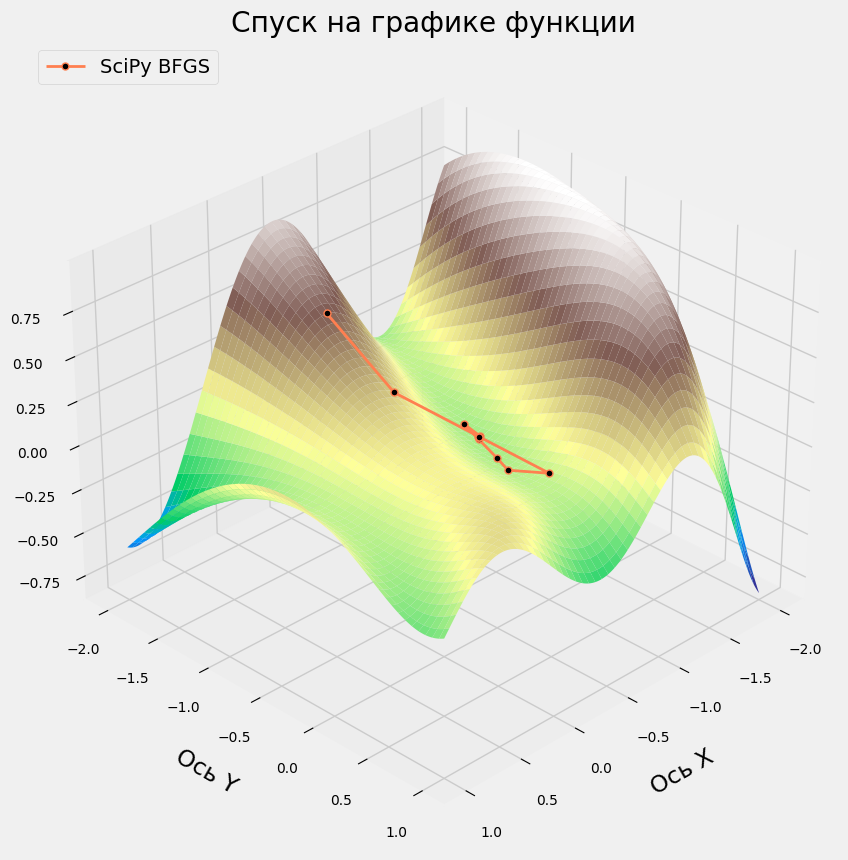

In [43]:
from matplotlib import pyplot as plt
from scipy.optimize import *
import math
import numpy as np
# from scipy.optimize import line_search


class file_info_3d:
    def __init__(self, X=None, Y=None, f=None, x0=None):
        self.X = X
        self.Y = Y
        self.Z = np.vectorize(lambda x, y: f(np.array([x, y])))(X, Y)
        self.f = f
        self.x0 = x0


def print_full_grad(file_info, list_result, list_label, title='Спуск на графике функции', elev=45, azim=50,
                    filename='', filename_extension='.png', dpi=1024, isshow=True):
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.plot_surface(file_info.X, file_info.Y, file_info.Z, linewidth=0, antialiased=True, shade=True, cmap='terrain')

    x = list_result[:, 0]
    y = list_result[:, 1]
    z = np.vectorize(lambda x, y: file_info.f(np.array([x, y])))(x, y)
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', color='coral', zs=z, label=list_label,
            linewidth=2)
    
    print(
        f'{list_label:15} ==> {file_info.f(list_result[-1]):10f} in [{list_result[-1][0]:10f}, {list_result[-1][1]:10f}] in {len(x)} steps.')

    ax.view_init(elev=elev, azim=azim)

    # Установка отступа между графиком и значениями осей
    ax.tick_params(pad=10)

    # Добавление легенды
    if len(list_label) > 0:
        ax.legend(loc='upper left')

    # Установка размера шрифта для подписей осей
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='z', labelsize=10)

    # Добавление заголовка и подписей осей
    if title != '':
        plt.title(title)

    ax.set_xlabel('Ось X', labelpad=20.0)
    ax.set_ylabel('Ось Y', labelpad=20.0)
    ax.set_zlabel('Ось f(x, y)', labelpad=20.0)

    if (filename != ''):
        plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()


def print_lines_grad(file_info_3d, result, label, nth=1, title='Спуск на графике функции', filename='',
                     filename_extension='.png', dpi=512):
    plt.style.use('default')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    list_result_nth = result[0::nth]

    if not np.array_equal(list_result_nth[-1], result[-1]):
        list_result_nth = np.vstack([list_result_nth, result[-1]])

    levels = np.unique(sorted([file_info_3d.f(p) for p in list_result_nth]))
    cs = ax.contour(file_info_3d.X, file_info_3d.Y, file_info_3d.Z, levels=levels, antialiased=True, linewidths=1.7,
                    cmap='tab10')
    cs.clabel()

    x = list_result_nth[:, 0]
    y = list_result_nth[:, 1]
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', color='coral', label=label, linewidth=1.8)
    print(
        f'{label:15} ==> '
        f'{file_info_3d.f(result[-1]):10f} in [{result[-1][0]:10f}, {result[-1][1]:10f}] in {len(result)} steps.')

    # Добавление заголовка и подписей осей
    if title != '':
        plt.title(title)

    # Добавление легенды
    if len(label) > 0:
        plt.legend(loc='upper left')

    if filename != '':
        plt.savefig(filename + '_lines' + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()


def grad(x, f, delta=1e-7):
    n = len(x)
    ans = np.zeros(n, dtype=float)
    params = x.copy()

    for j in range(n):
        params[j] += delta
        f_plus = f(params)
        params[j] -= delta
        params[j] -= delta
        f_minus = f(params)
        params[j] += delta
        ans[j] = np.divide(f_plus - f_minus, 2 * delta)

    return ans


def bfgs(initial_w, func, grad_func, max_iter=1000, tolerance=1e-9, eps=1e-10):
    result = [np.copy(initial_w)]
    current_x = np.copy(initial_w)
    n = len(initial_w)
    H = np.identity(n)

    for i in range(max_iter):
        grad_f = grad_func(current_x, func)
        p = -1 * H @ grad_f
        alpha, _, _, _, _, _ = line_search(func, grad_func, current_x, p, args=(f, ))

        if alpha is None:
            alpha = 1e-3

        new_x = current_x + alpha * p
        new_grad_f = grad_func(new_x, func)

        y = new_grad_f - grad_f
        s = new_x - current_x

        rho = 1 / (y.T @ s + eps)
        H = (np.identity(n) - rho * y @ s.T) @ H @ (np.identity(n) - rho * y @ s.T) + rho * s @ s.T

        if np.linalg.norm(grad_f) < tolerance:
            break

        current_x = new_x
        result.append(current_x)

    return result


def compare(func, initial_x, x_lin, y_lin, max_iter=10, elev=(30, 30), azim=(45, 45)):
    # Our implementation
    result_definition = bfgs(initial_x, func, grad, max_iter=max_iter)

    # SciPy implementation
    result_scipy = minimize(func, initial_x, method='BFGS', options={'maxiter' : max_iter, 'gtol' : 1e-9, 'return_all' : True})

    X, Y = np.meshgrid(x_lin, y_lin)
    f_info = file_info_3d(X, Y, func, initial_x)

    print('Our implementation')
    print_lines_grad(f_info, np.array(result_definition), 'BFGS')
    print_full_grad(f_info, np.array(result_definition), 'BFGS', elev=elev[0], azim=azim[0])

    print('SciPy implementation')
    print_lines_grad(f_info, np.array(result_scipy['allvecs']), 'SciPy BFGS')
    print_full_grad(f_info, np.array(result_scipy['allvecs']), 'SciPy BFGS', elev=elev[1], azim=azim[1])


def f_lecture(x, _=None):
    return np.sin(0.5 * x[0] ** 2 - 0.25 * x[1] ** 2 + 3) * np.cos(2 * x[0] + 1 - np.exp(x[1]))

def f_himmelblau(x, _=None):
    return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2


_ = plt.figure(figsize=(8, 8))

initial_x = np.array([-0.3, -1.4])

x_lin = np.linspace(-2, 1, 200, dtype=float)
y_lin = np.linspace(-2, 1, 200, dtype=float)


compare(f_lecture, initial_x, x_lin, y_lin)

/Users/mac/JetBrains_Projects/PycharmProjects/MetOpt/venv/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Our implementation
BFGS            ==>   0.013730 in [  3.596891,  -1.870625] in 25 steps.


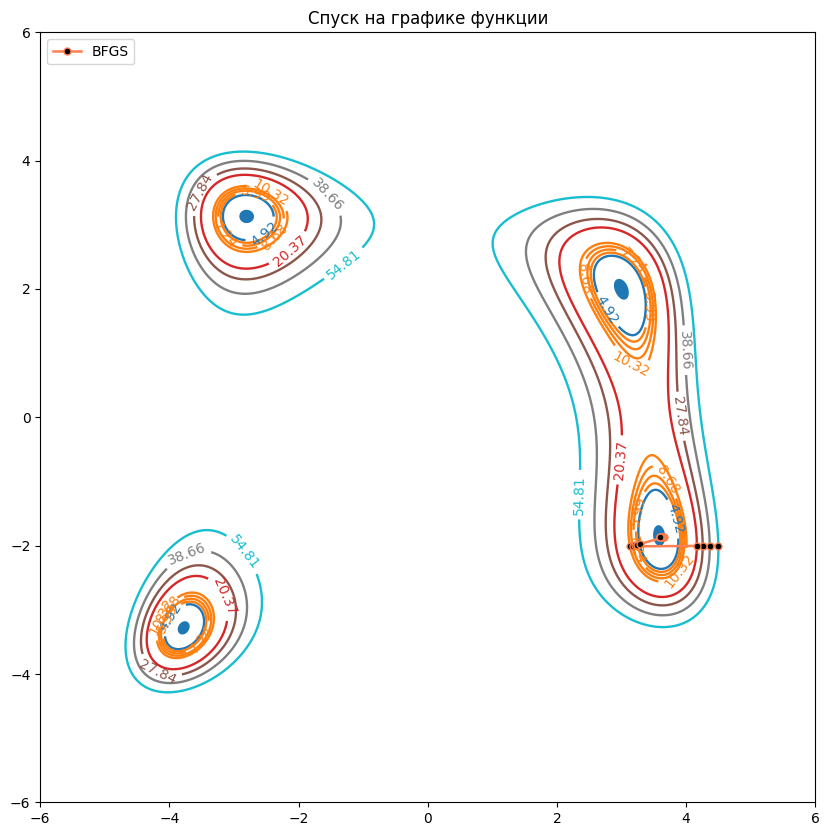

BFGS            ==>   0.013730 in [  3.596891,  -1.870625] in 25 steps.


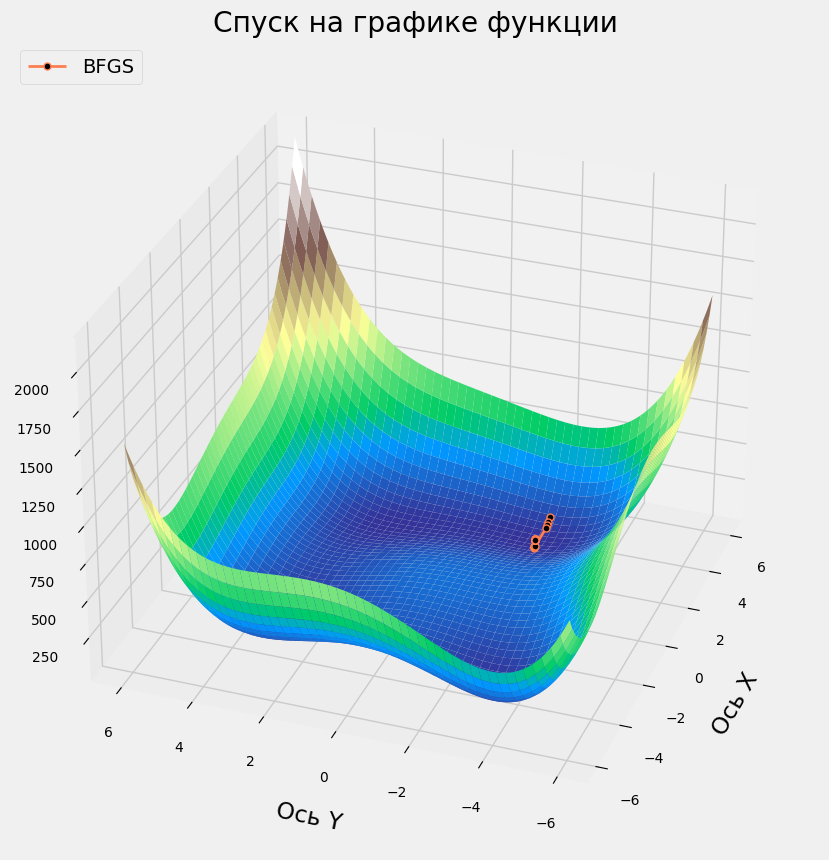

SciPy implementation
SciPy BFGS      ==>   0.000000 in [  3.584428,  -1.848127] in 9 steps.


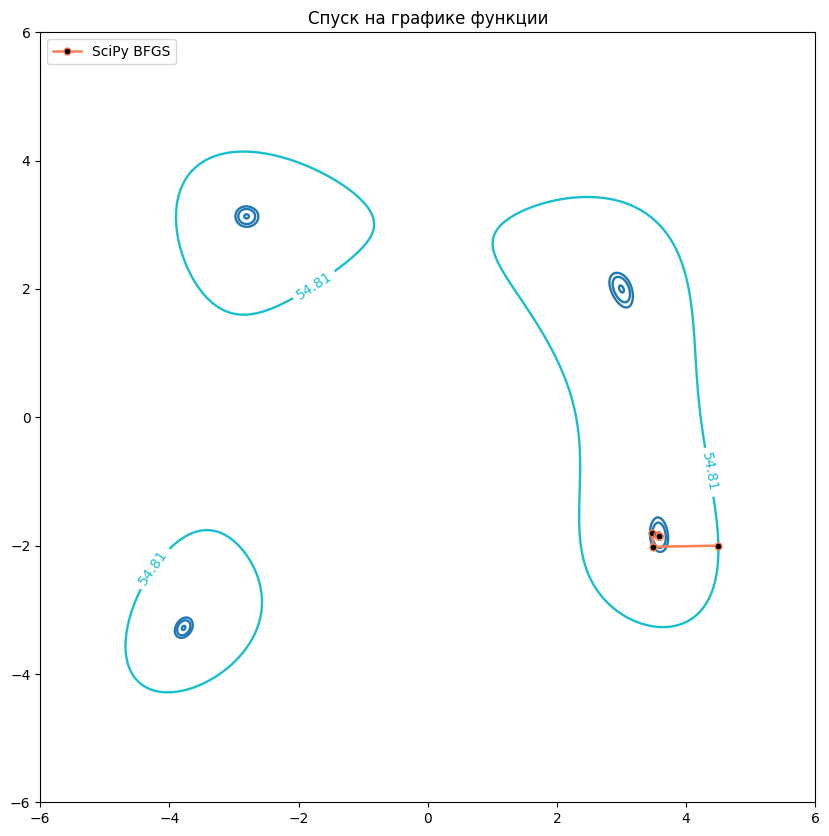

SciPy BFGS      ==>   0.000000 in [  3.584428,  -1.848127] in 9 steps.


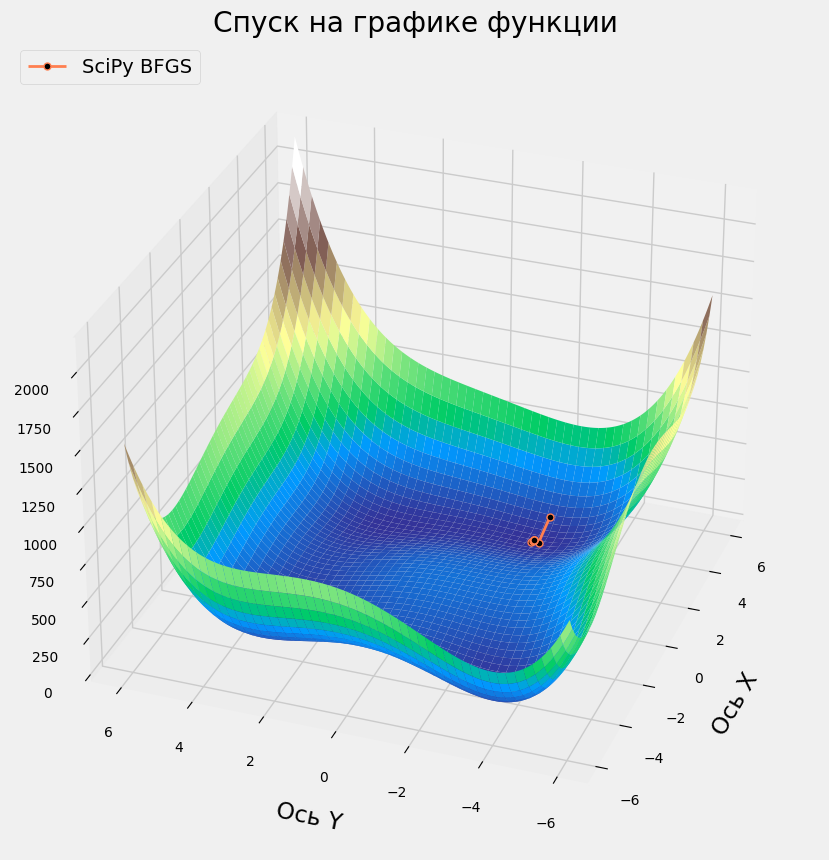

In [52]:
initial_x = np.array([4.5, -2.0])

x_lin = np.linspace(-6, 6, 1200, dtype=float)
y_lin = np.linspace(-6, 6, 1200, dtype=float)


compare(f_himmelblau, initial_x, x_lin, y_lin, max_iter=24, elev=(30, 30), azim=(200, 200))